In [33]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

Fontconfig warning: ignoring UTF-8: not a valid region tag


## Loading dataset

Before running this experiment please make sure you have downloaded a dataset to a specified location.
You can do it by running `python scripts/dataset.py`.

See `README.md` for detailed instructions.

In [14]:
movies = pd.read_csv('../../data/ml-1m/movies.dat', sep='::', header=None, names=['movie_id', 'title', 'genres'], engine='python', encoding='latin-1')
ratings = pd.read_csv('../../data/ml-1m/ratings.dat', sep='::', header=None, names=['user_id', 'movie_id', 'rating', 'timestamp'], engine='python', encoding='latin-1')
users = pd.read_csv('../../data/ml-1m/users.dat', sep='::', header=None, names=['user_id', 'gender', 'age', 'occupation', 'zip_code'], engine='python', encoding='latin-1')

In [15]:
movies.head()

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [16]:
ratings.head()

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [17]:
users.head()

,user_id,gender,age,occupation,zip_code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


Dataset is loaded fine, let's move on with Page Rank Graph.

We decided to make graph using `networkx` package.

Graph consists of `user_id`, `movie_id` and `rating` as a weights.

In [18]:
# Graph initialization
G = nx.Graph()

In [19]:
# Adding nodes with the bipartite attributes
user_nodes = ratings['user_id'].unique()
movie_nodes = ratings['movie_id'].unique()

G.add_nodes_from(user_nodes, bipartite=0)
G.add_nodes_from(movie_nodes, bipartite=1)

In [20]:
# Now we addind enges using ratings as a weights
edges = [(row['user_id'], row['movie_id'], row['rating']) for index, row in ratings.iterrows()]
G.add_weighted_edges_from(edges)

In [22]:
# Now we can proceed with Page Rank
pagerank_scores = nx.pagerank(G, weight='weight')

Since we have a Page Rank scores, we can now separate users and movies scores in order to procced.

In [24]:
user_pagerank = {k: v for k, v in pagerank_scores.items() if k in user_nodes}
movie_pagerank = {k: v for k, v in pagerank_scores.items() if k in movie_nodes}

For analysis purposes let's display top 10 users and movies respectively.

In [28]:
# Using pandas DataFrame to make displaing a little bit fancier.
top_users = sorted(user_pagerank.items(), key=lambda x: x[1], reverse=True)[:10]
top_movies = sorted(movie_pagerank.items(), key=lambda x: x[1], reverse=True)[:10]

pd.DataFrame(top_users, columns=['ID', 'Score'])

,ID,Score
0,2858,0.002162
1,260,0.001858
2,1196,0.001765
3,1210,0.001615
4,2028,0.001597
5,593,0.001565
6,2762,0.001548
7,1198,0.001547
8,2571,0.001517
9,589,0.001464


In [30]:
pd.DataFrame(top_movies, columns=['ID', 'Score'])

,ID,Score
0,2858,0.002162
1,260,0.001858
2,1196,0.001765
3,1210,0.001615
4,2028,0.001597
5,593,0.001565
6,2762,0.001548
7,1198,0.001547
8,2571,0.001517
9,589,0.001464


Now let's create a plot to keep a results a little more representative

In [39]:
all_users = sorted(user_pagerank.items(), key=lambda x: x[1], reverse=True)
all_movies = sorted(movie_pagerank.items(), key=lambda x: x[1], reverse=True)

all_user_ids, all_user_scores = zip(*all_users)
all_movie_ids, all_movie_scores = zip(*all_movies)

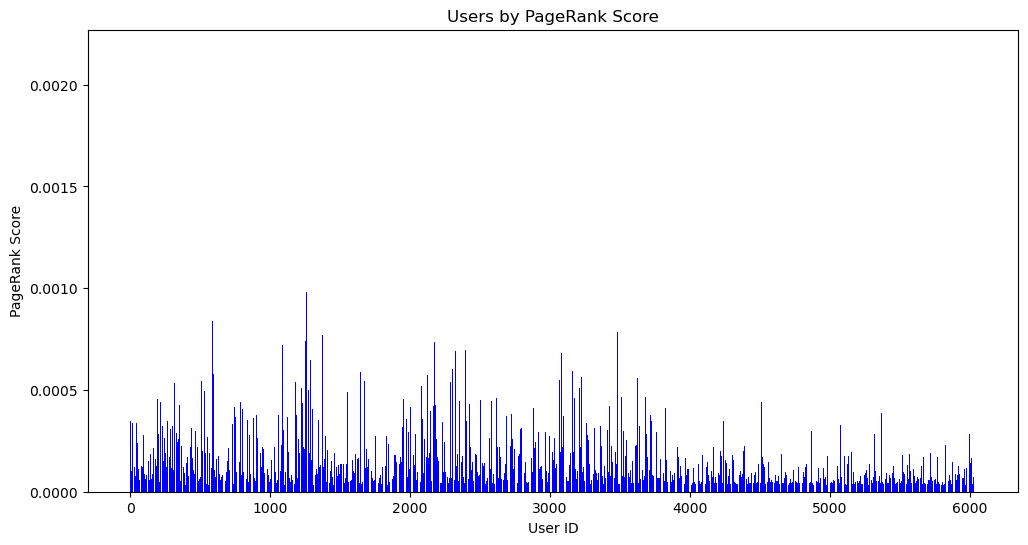

In [42]:
plt.figure(figsize=(12, 6))
plt.bar(all_user_ids, all_user_scores, color='blue')
plt.xlabel('User ID')
plt.ylabel('PageRank Score')
plt.title('Users by PageRank Score')
plt.show()

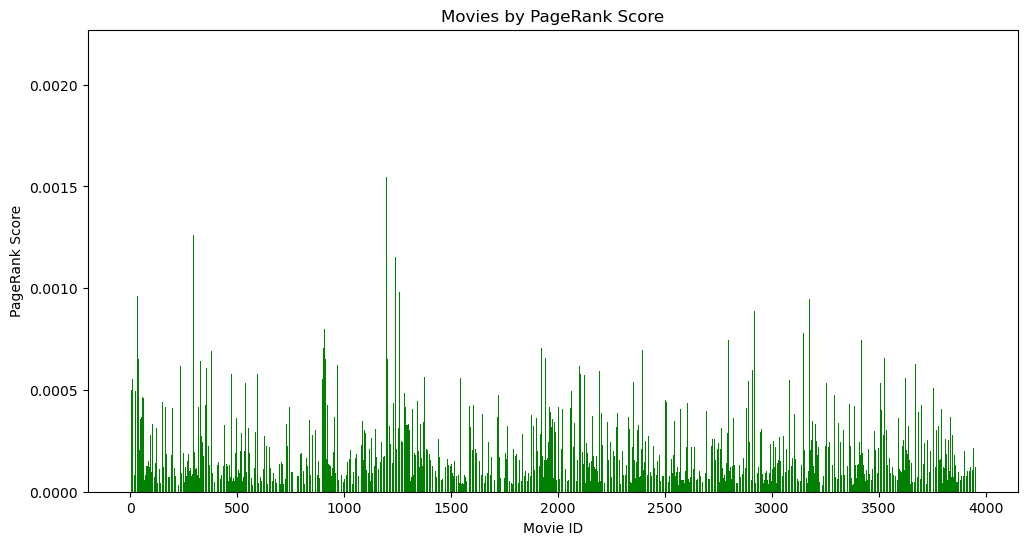

In [44]:
plt.figure(figsize=(12, 6))
plt.bar(all_movie_ids, all_movie_scores, color='green')
plt.xlabel('Movie ID')
plt.ylabel('PageRank Score')
plt.title('Movies by PageRank Score')
plt.show()

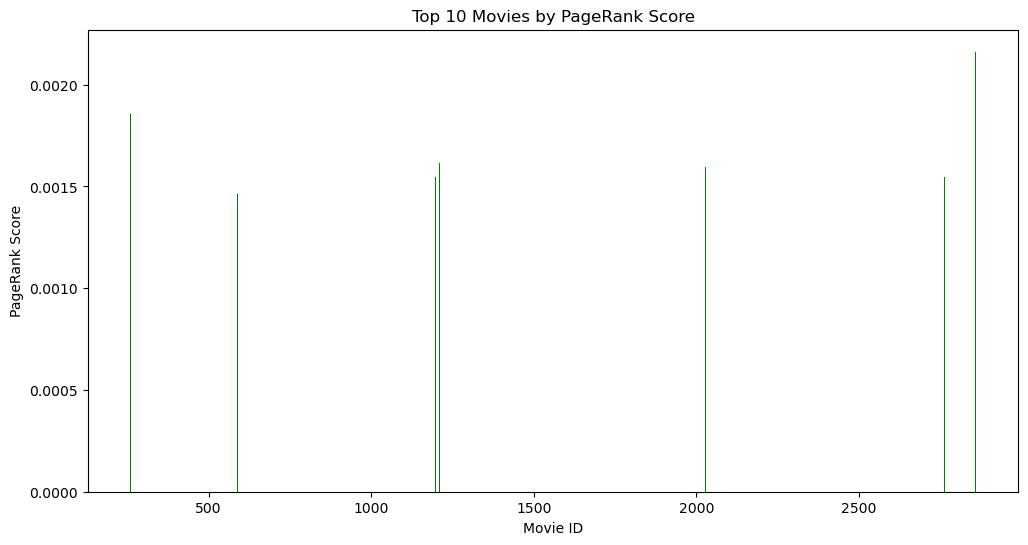

In [45]:
top_movie_ids, top_movie_scores = zip(*top_movies)
plt.figure(figsize=(12, 6))
plt.bar(top_movie_ids, top_movie_scores, color='green')
plt.xlabel('Movie ID')
plt.ylabel('PageRank Score')
plt.title('Top 10 Movies by PageRank Score')
plt.show()

## Interpretation of results and some thoughts about Page Rank and its usability in case of a part of recommender system

Using a Page Rank algoritm we found two key features, that can be handy.
- **Users with high PageRank**
    
    There users can be interpreted as highly influantial in our system, meaning that they have rated many popular movies in our case. Using those values we can fine tune our recommendation system to make ratings of those users as a more important when suggesting movies to other users.
    
    
- **Movies with high PageRank**

    Those movies are generally high rated and well-connected with user-movie graph. We can use those movies as an popular or high-quality. So we can make a prioretization in recommendation lists.
    
In general by usign a PageRank we can identify influentional users and popular movies, this information can be used as an part of recommendation strategy by focusing on some core users and popular movies that can be prioritized.

Also we can you PageRank scored to enhance an accurancy of collaborative filtering by giving users with high influence more weights when we calculate similarities.

### Disadvantages of using PageRank
- Computation Complexity
    
    Algoritm eather time-consuming or memory-consuming.
    We should store those matrices somewhere in memory which can be as significant problem in general.
    
- Algoritm is biased to a popular nodes.
    PageRank tents to flavor nodes with many connections.
    It may lead to recommending only popular nodes, completly ignoring new ones.

Also PageRank has static structure - meaning that we should recalculate graph often leading to our first problem.

## Improvements

We can slightly impove general algoritm by adding personalized PageRank scores for every particular (This would drain memory fast, but can improve general recommendations)

What we should do to implement personalized PageRank

-  Create Personalization Vector

    The personalization vector is a probabilities distribution over the nodes in the graph. For a end user, this vector assigns higher probabilities to nodes (movies) that the user is interested in.
    In our case if user has rates some movies highly, we take this movies as higher influence movies
    
Modifications to PageRank

$$
PR(u) = \frac{1 - d}{N} \sum_{v \in B_{u}} \frac{PR(v)}{L(v)} + d * p_u
$$

Where:
* $PR(u)$ is the PageRank on node $u$
* $d$ is damping factor
* $B_u$ is a set of nodes that link to $u$
* $L(v)$ is number of outbound links from $v$
* $p_u$ is pesonalization probability of $u$

Baseline implementation are not changed.
Let's apply those modification to some user.

In [46]:
user_id = 1 # Sample User
user_ratings = ratings[ratings['user_id'] == user_id]
personalization = {node: 0 for node in G.nodes()}
for movie_id in user_ratings['movie_id']:
    personalization[movie_id] = 1 / len(user_ratings)

In [47]:
personalized_pagerank = nx.pagerank(G, personalization=personalization, weight='weight')

In [48]:
movie_pagerank = {k: v for k, v in personalized_pagerank.items() if k in movie_nodes}
top_personalized_movies = sorted(movie_pagerank.items(), key=lambda x: x[1], reverse=True)[:10]

In [50]:
pd.DataFrame(top_personalized_movies, columns=['ID', 'Score'])

,ID,Score
0,260,0.004351
1,2028,0.004148
2,2762,0.004074
3,608,0.004068
4,527,0.004062
5,1197,0.004009
6,1270,0.004006
7,1,0.003972
8,1097,0.003928
9,919,0.003837


This version will benefit in case to create a user specific recommendations  as well as improved handling of Diverse Interests

But it will dramatically increase compuration resources needed to perform this algoritm as well as memory needed to store all matrices for every user.